In [1]:
!pip install folium

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import folium                                 # Visualização de mapas
import catboost

from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from folium.plugins import HeatMap
from folium.plugins import FastMarkerCluster
from sklearn.metrics import log_loss

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-crime/test.csv.zip
/kaggle/input/sf-crime/train.csv
/kaggle/input/sf-crime/sf_map_copyright_openstreetmap_contributors.rds
/kaggle/input/sf-crime/sf_map_copyright_openstreetmap_contributors.txt
/kaggle/input/sf-crime/train.csv.zip
/kaggle/input/sf-crime/sampleSubmission.csv
/kaggle/input/sf-crime/test.csv


In [3]:
df_train = pd.read_csv('../input/sf-crime/train.csv')
df_test = pd.read_csv('../input/sf-crime/test.csv')

In [4]:
df_train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [5]:
df_test.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


In [6]:
df_train.describe()

,X,Y
count,878049.000000,878049.000000
mean,-122.422616,37.771020
std,0.030354,0.456893
min,-122.513642,37.707879
25%,-122.432952,37.752427
50%,-122.416420,37.775421
75%,-122.406959,37.784369
max,-120.500000,90.000000


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
Dates         878049 non-null object
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


# Pré-Processamento

Removendo valores duplicados

In [8]:
print(df_train.duplicated().sum())
df_train.drop_duplicates(inplace=True)
print(df_train.duplicated().sum())

2323
0


Retirando as classes e valores categoricos do conjunto de treino

In [9]:
y = df_train['Category']
df_train_description = df_train['Descript']
df_train_resolution = df_train['Resolution']

In [10]:
df_train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


Retirando coluna ID da conjunto de test e armazenando para uso posterior

In [11]:
test_ID = df_test["Id"]
df_test.drop("Id", axis=1, inplace=True)

In [12]:
df_test.head()

,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


In [13]:
y.value_counts()

LARCENY/THEFT                  174320
OTHER OFFENSES                 125960
NON-CRIMINAL                    91915
ASSAULT                         76815
DRUG/NARCOTIC                   53919
VEHICLE THEFT                   53706
VANDALISM                       44581
WARRANTS                        42145
BURGLARY                        36600
SUSPICIOUS OCC                  31394
MISSING PERSON                  25669
ROBBERY                         22988
FRAUD                           16637
FORGERY/COUNTERFEITING          10592
SECONDARY CODES                  9979
WEAPON LAWS                      8550
PROSTITUTION                     7446
TRESPASS                         7318
STOLEN PROPERTY                  4537
SEX OFFENSES FORCIBLE            4380
DISORDERLY CONDUCT               4313
DRUNKENNESS                      4277
RECOVERED VEHICLE                3132
KIDNAPPING                       2340
DRIVING UNDER THE INFLUENCE      2268
LIQUOR LAWS                      1899
RUNAWAY     

Codificando as classe (categoricas) para valores numericos

In [14]:
le = LabelEncoder()
y = le.fit_transform(y)
print(le.classes_)

['ARSON' 'ASSAULT' 'BAD CHECKS' 'BRIBERY' 'BURGLARY' 'DISORDERLY CONDUCT'
 'DRIVING UNDER THE INFLUENCE' 'DRUG/NARCOTIC' 'DRUNKENNESS'
 'EMBEZZLEMENT' 'EXTORTION' 'FAMILY OFFENSES' 'FORGERY/COUNTERFEITING'
 'FRAUD' 'GAMBLING' 'KIDNAPPING' 'LARCENY/THEFT' 'LIQUOR LAWS' 'LOITERING'
 'MISSING PERSON' 'NON-CRIMINAL' 'OTHER OFFENSES'
 'PORNOGRAPHY/OBSCENE MAT' 'PROSTITUTION' 'RECOVERED VEHICLE' 'ROBBERY'
 'RUNAWAY' 'SECONDARY CODES' 'SEX OFFENSES FORCIBLE'
 'SEX OFFENSES NON FORCIBLE' 'STOLEN PROPERTY' 'SUICIDE' 'SUSPICIOUS OCC'
 'TREA' 'TRESPASS' 'VANDALISM' 'VEHICLE THEFT' 'WARRANTS' 'WEAPON LAWS']


Separendo datas em counos proprias paa casa seguimento e criando atribudos novos baseados neles

In [15]:
def create_update_time_of_day_features(df_, dic_labels):
    """
        Create a feature time of day or period from datatime
            Examples: 
                datetime1 = 2019-04-28 02:00:56 -> period = early morning
                datetime2 = 2019-04-28 08:00:56 -> period = morning
                datetime3 = 2019-04-28 14:00:56 -> period = afternoon
                datetime4 = 2019-04-28 20:00:56 -> period = evening
    """
    try:
        print('\nCreating or updating period feature\n...early morning from 0H to 6H\n...morning from 6H to 12H\n...afternoon from 12H to 18H\n...evening from 18H to 24H')
        conditions =   [(df_[dic_labels['datetime']].dt.hour >= 0) & (df_[dic_labels['datetime']].dt.hour < 6), 
                        (df_[dic_labels['datetime']].dt.hour >= 6) & (df_[dic_labels['datetime']].dt.hour < 12),
                        (df_[dic_labels['datetime']].dt.hour >= 12) & (df_[dic_labels['datetime']].dt.hour < 18),  
                        (df_[dic_labels['datetime']].dt.hour >= 18) & (df_[dic_labels['datetime']].dt.hour < 24)]
        choices = ['early morning', 'morning', 'afternoon', 'evening']
        df_['PeriodOfDay'] = np.select(conditions, choices, 'undefined')      
        print('...the period of day feature was created')
    except Exception as e:
        raise e

Criando atributo periodo do dia em que ocorreu

In [16]:
df_train['Dates'] = pd.to_datetime(df_train['Dates'])
df_test['Dates'] = pd.to_datetime(df_test['Dates'])
create_update_time_of_day_features(df_train,dic_labels={'datetime' : 'Dates'})
create_update_time_of_day_features(df_test,dic_labels={'datetime' : 'Dates'})


Creating or updating period feature
...early morning from 0H to 6H
...morning from 6H to 12H
...afternoon from 12H to 18H
...evening from 18H to 24H
...the period of day feature was created

Creating or updating period feature
...early morning from 0H to 6H
...morning from 6H to 12H
...afternoon from 12H to 18H
...evening from 18H to 24H
...the period of day feature was created


Separando data nos atributos anos, mes, dia, hora, minuto e a quantidade de dias em relacao a ocorrencia mais antiga

In [17]:
df_train['year'] = df_train['Dates'].dt.year
df_train['month'] = df_train['Dates'].dt.month
df_train['day'] = df_train['Dates'].dt.day
df_train['hour'] = df_train['Dates'].dt.hour
df_train['minute'] = df_train['Dates'].dt.minute
df_train["n_days"] = (df_train['Dates'] - df_train['Dates'].min()).apply(lambda x: x.days)
df_train.drop("Dates", axis=1, inplace=True)

In [18]:
df_test['year'] = df_test['Dates'].dt.year
df_test['month'] = df_test['Dates'].dt.month
df_test['day'] = df_test['Dates'].dt.day
df_test['hour'] = df_test['Dates'].dt.hour
df_test['minute'] = df_test['Dates'].dt.minute
df_test["n_days"] = (df_test['Dates'] - df_test['Dates'].min()).apply(lambda x: x.days)
df_test.drop("Dates", axis=1, inplace=True)

In [19]:
df_train.head()

,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,PeriodOfDay,year,month,day,hour,minute,n_days
0,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,evening,2015,5,13,23,53,4510
1,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,evening,2015,5,13,23,53,4510
2,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,evening,2015,5,13,23,33,4510
3,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,evening,2015,5,13,23,30,4510
4,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,evening,2015,5,13,23,30,4510


In [20]:
df_train["DayOfWeek"].value_counts()

Friday       133371
Wednesday    128829
Saturday     126469
Thursday     124757
Tuesday      124603
Monday       121303
Sunday       116394
Name: DayOfWeek, dtype: int64

In [21]:
df_train["DayOfWeek"].value_counts()

Friday       133371
Wednesday    128829
Saturday     126469
Thursday     124757
Tuesday      124603
Monday       121303
Sunday       116394
Name: DayOfWeek, dtype: int64

In [22]:
import folium

saoFrancisco = folium.Map(
    location=[37.762657, -122.435792],
    zoom_start=12
)
for _, ponto in df_train.head(1000).iterrows():
    folium.Marker(
       location=[ponto['Y'], ponto['X']]
    ).add_to(saoFrancisco)

saoFrancisco

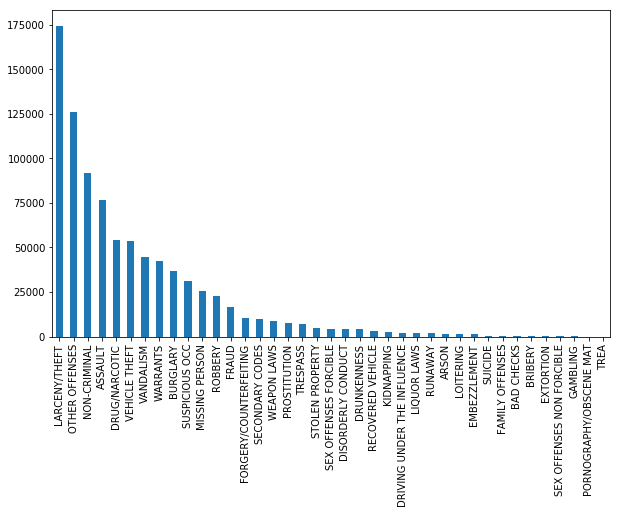

In [23]:
df_train['Category'].value_counts().plot(kind='bar', figsize=(10,6));

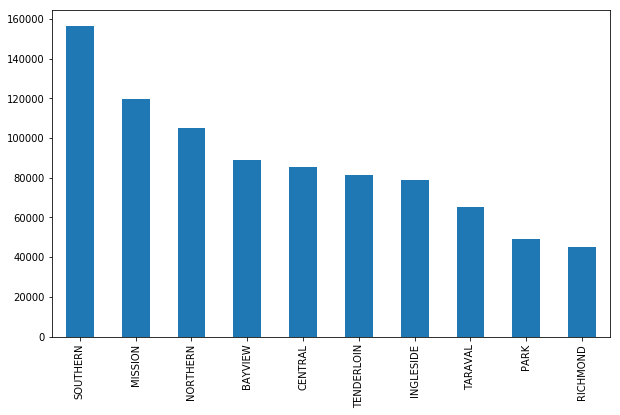

In [24]:
df_train['PdDistrict'].value_counts().plot(kind='bar', figsize=(10,6));

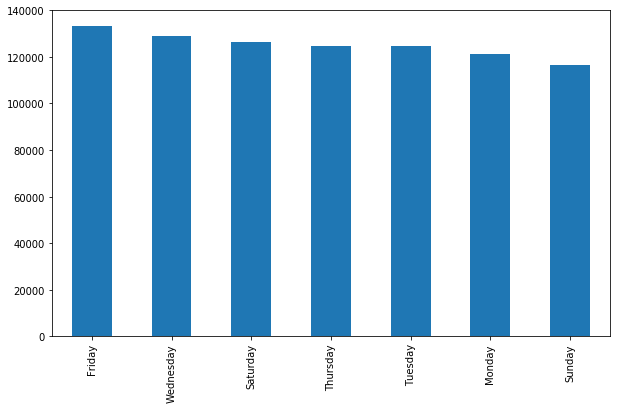

In [25]:
df_train['DayOfWeek'].value_counts().plot(kind='bar', figsize=(10,6)); 

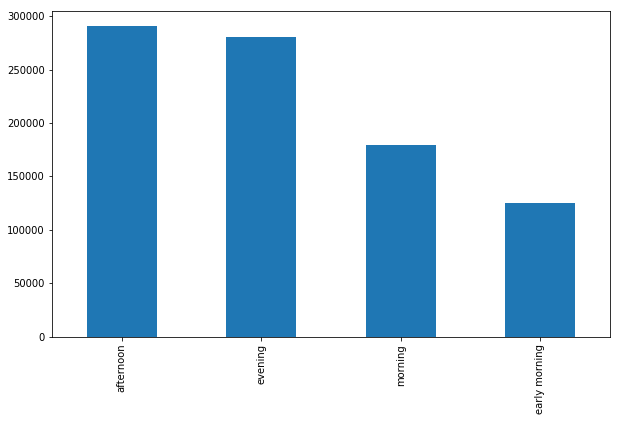

In [26]:
df_train['PeriodOfDay'].value_counts().plot(kind='bar', figsize=(10,6));

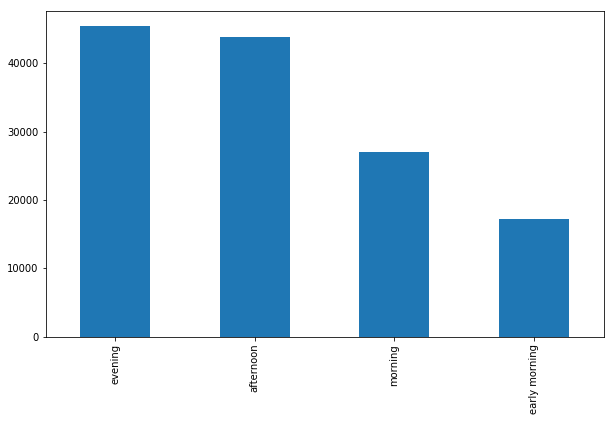

In [27]:
df_train[df_train['DayOfWeek'] == 'Friday']['PeriodOfDay'].value_counts().plot(kind='bar', figsize=(10,6));

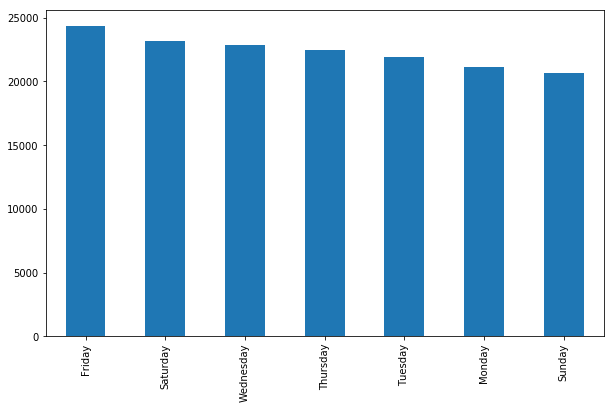

In [28]:
df_train[df_train['PdDistrict'] == 'SOUTHERN']['DayOfWeek'].value_counts().plot(kind='bar', figsize=(10,6));

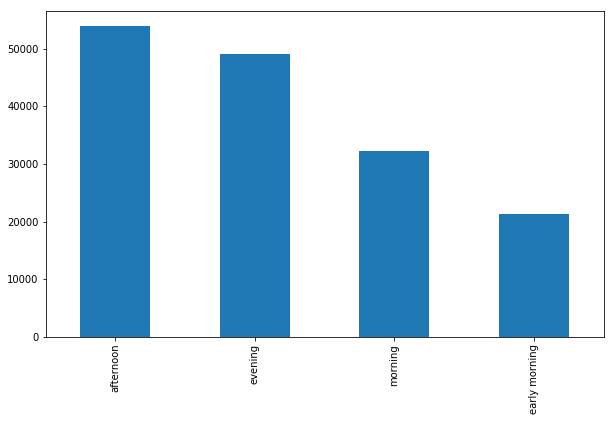

In [29]:
df_train[df_train['PdDistrict'] == 'SOUTHERN']['PeriodOfDay'].value_counts().plot(kind='bar', figsize=(10,6));

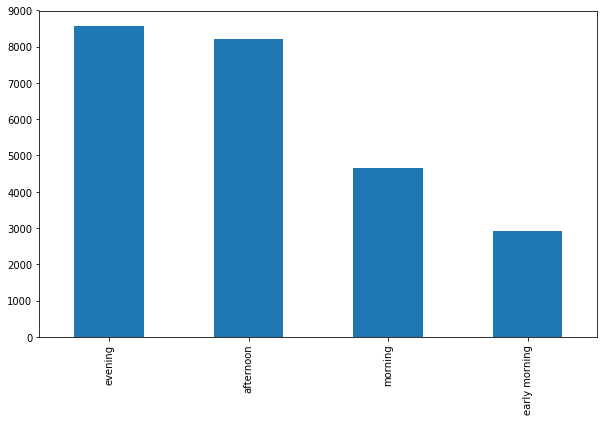

In [30]:
SOUTHERN = df_train[df_train['PdDistrict'] == 'SOUTHERN']
SOUTHERN[SOUTHERN['DayOfWeek'] == 'Friday']['PeriodOfDay'].value_counts().plot(kind='bar', figsize=(10,6));

Exclussão de atributos categorigos que nao serão usados

In [31]:
df_train.drop(["Category", "Descript", "Resolution", "Address"], axis=1, inplace=True)
df_test.drop("Address", axis=1, inplace=True)

In [32]:
df_train.head()

,DayOfWeek,PdDistrict,X,Y,PeriodOfDay,year,month,day,hour,minute,n_days
0,Wednesday,NORTHERN,-122.425892,37.774599,evening,2015,5,13,23,53,4510
1,Wednesday,NORTHERN,-122.425892,37.774599,evening,2015,5,13,23,53,4510
2,Wednesday,NORTHERN,-122.424363,37.800414,evening,2015,5,13,23,33,4510
3,Wednesday,NORTHERN,-122.426995,37.800873,evening,2015,5,13,23,30,4510
4,Wednesday,PARK,-122.438738,37.771541,evening,2015,5,13,23,30,4510


In [33]:
df_test.head()

,DayOfWeek,PdDistrict,X,Y,PeriodOfDay,year,month,day,hour,minute,n_days
0,Sunday,BAYVIEW,-122.399588,37.735051,evening,2015,5,10,23,59,4512
1,Sunday,BAYVIEW,-122.391523,37.732432,evening,2015,5,10,23,51,4512
2,Sunday,NORTHERN,-122.426002,37.792212,evening,2015,5,10,23,50,4512
3,Sunday,INGLESIDE,-122.437394,37.721412,evening,2015,5,10,23,45,4512
4,Sunday,INGLESIDE,-122.437394,37.721412,evening,2015,5,10,23,45,4512


Trasformando atributos categoricos em ordinal

In [34]:
categorical_features = ["DayOfWeek", "PdDistrict", "PeriodOfDay"]
ct = ColumnTransformer(transformers=[("categorical_features", OrdinalEncoder(), categorical_features)],
                       remainder="passthrough")
df_train = ct.fit_transform(df_train)

In [35]:
categorical_features = ["DayOfWeek", "PdDistrict","PeriodOfDay"]
ct = ColumnTransformer(transformers=[("categorical_features", OrdinalEncoder(), categorical_features)],
                       remainder="passthrough")
df_test = ct.fit_transform(df_test)

# Separacao dos dados (treino e teste)

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(df_train, y, test_size=0.25, random_state=42,stratify=y)

In [38]:
from sklearn.preprocessing import StandardScaler

In [39]:
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)
X_predict_std = StandardScaler().fit_transform(df_test)

## Predicao com CatBoostClassifier

Oproblema que deu nessa modelo era que não tinha ativado a GPU do kaggle

In [40]:
cbc = catboost.CatBoostClassifier(n_estimators=2000, learning_rate=0.05,
                                  random_seed=0, task_type="GPU", verbose=50)

In [47]:
cbc.fit(X_train_std, y_train)
prob = cbc.predict_proba(X_predict_std)

0:	learn: 3.4855640	total: 70.6ms	remaining: 2m 21s
50:	learn: 2.4832307	total: 3.36s	remaining: 2m 8s
100:	learn: 2.4229802	total: 6.57s	remaining: 2m 3s
150:	learn: 2.3994238	total: 9.77s	remaining: 1m 59s
200:	learn: 2.3839914	total: 13s	remaining: 1m 56s
250:	learn: 2.3712483	total: 16.2s	remaining: 1m 52s
300:	learn: 2.3604129	total: 19.4s	remaining: 1m 49s
350:	learn: 2.3507289	total: 22.5s	remaining: 1m 45s
400:	learn: 2.3422692	total: 25.7s	remaining: 1m 42s
450:	learn: 2.3353873	total: 28.9s	remaining: 1m 39s
500:	learn: 2.3292235	total: 32.3s	remaining: 1m 36s
550:	learn: 2.3230979	total: 36.1s	remaining: 1m 34s
600:	learn: 2.3176970	total: 39.3s	remaining: 1m 31s
650:	learn: 2.3122197	total: 42.5s	remaining: 1m 28s
700:	learn: 2.3076041	total: 45.8s	remaining: 1m 24s
750:	learn: 2.3027559	total: 49s	remaining: 1m 21s
800:	learn: 2.2984202	total: 52.2s	remaining: 1m 18s
850:	learn: 2.2937194	total: 55.4s	remaining: 1m 14s
900:	learn: 2.2894366	total: 58.6s	remaining: 1m 11s
9

In [48]:
submission = pd.DataFrame(np.c_[test_ID, prob], columns=["Id"] + list(le.classes_))
submission["Id"] = submission["Id"].astype(int)
submission.to_csv("submission.csv", index=False)

In [44]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#### Teste com random foreste

In [49]:
from sklearn.ensemble import RandomForestClassifier

In [50]:
RF = RandomForestClassifier(n_estimators=1000,criterion='entropy',max_depth=10)
RF.fit(X_train_std,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [51]:
y_pred_RF = RF.predict(X_test_std)

In [53]:
print(' Accuracy|',accuracy_score(y_test,y_pred_RF))
print('Precision|',precision_score(y_test,y_pred_RF,average='macro'))

 Accuracy| 0.27178301938501453


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

# Teste com rede neural

In [ ]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Embedding, Dense

In [ ]:
model = Sequential()

In [ ]:
model.add(Dense(26,input_dim=26, activation='relu'))
model.add(Dense(13,activation='relu'))
model.add(Dense(6,activation='relu'))
model.add(Dense(1,activation='relu'))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='sgd',loss='mse',metrics=['mae','acc'])

In [ ]:
from keras.callbacks import EarlyStopping

In [ ]:
callback_early = EarlyStopping(min_delta=0.01,patience=20)

In [ ]:
history = model.fit(x=X_train_std,y=y_train, batch_size=10, epochs=50,validation_split=0.1,callbacks=[callback_early])

In [ ]:
loss, mae, acc = model.evaluate(X_test_std,y_test)
loss, mae, acc

In [ ]:
ypred_RN = model.predict(X_test_std)

In [ ]:
print(' Accuracy|',accuracy_score(y_test,ypred_RN))
print('Precision|',precision_score(y_test,ypred_RN,average='macro'))

In [ ]:
RF = RandomForestClassifier(n_estimators=1000,criterion='entropy',max_depth=15)

In [ ]:
RF.fit(X_train_std,y_train)

In [ ]:
y_pred_RF = RF.predict(X_predict_std)

In [ ]:
# Y = le.classes_

In [ ]:
# submit = pd.DataFrame({'Id': df_test.Id.tolist()})
# for category in np.unique(Y):
#     submit[category] = np.where(y_pred_RF == category, 1, 0)

In [ ]:
# submit.to_csv('San_Francisco_Crime_RF.csv', index = False)